# CNN Convolutional Network 

# I. Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adamax

import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm.notebook import tqdm

2024-06-11 17:45:58.592474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 17:45:58.592611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 17:45:58.725122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# II. HyperParameters And Directories

In [2]:
TRAIN_DIR = '../input/fer2013/train/'
TEST_DIR = '../input/fer2013/test/'

In [6]:
IMG_SIZE = 48
NUM_CHANNELS=1
BATCH_SIZE = 64
EPOCHS = 20

In [3]:
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        validation_split=0.2,
        fill_mode='nearest')

test_data_generator = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)

# Common Functions

In [4]:
def get_predictions(model, test_data):
    return np.argmax(model.predict(test_data), axis=-1)

In [5]:
def get_data_generators(img_size,  num_channels, batch_size=64):
    color_mode = "grayscale" if num_channels == 1 else "rgb"
    
    train_data = train_data_generator.flow_from_directory(
        directory=TRAIN_DIR,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode="categorical",
        subset="training")

    validation_data = train_data_generator.flow_from_directory(
        directory=TRAIN_DIR,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode="categorical",
        subset="validation")

    test_data = test_data_generator.flow_from_directory(
        directory=TEST_DIR,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode="categorical")
    
    test_unshuffled_data = test_data_generator.flow_from_directory(
    TEST_DIR,
    class_mode="categorical",
    target_size=(img_size, img_size),
    color_mode=color_mode,
    shuffle=False,
    batch_size=batch_size)

    return train_data, validation_data, test_data, test_unshuffled_data

In [4]:
def evaluate_model_x_y(model, x_test_data,y_test_data):
    test_data_evaluation = model.evaluate(x_test_data, y_test_data)
    print("Test Accuracy: {:.2f}%".format(test_data_evaluation[1] * 100))
    print("Test Loss: {:.5f}".format(test_data_evaluation[0]))

In [6]:
def evaluate_model(model,test_data):
    test_data_evaluation=model.evaluate(test_data)
    print("Test Accuracy: {:.2f}%".format(test_data_evaluation[1] * 100))
    print("Test Loss: {:.5f}".format(test_data_evaluation[0]))

# Common Visualization Functions

In [7]:
def visualize_performance_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "validation_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "validation_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.grid(True)

    plt.legend()

    plt.tight_layout()
    plt.show()

In [26]:
def overview_training_statistics_x_y(model, x_test_data, y_test_data, history):
    evaluate_model_x_y(model, x_test_data, y_test_data)
    visualize_performance_curves(history)

In [8]:
def overview_training_statistics(model, test_data, history):
    evaluate_model(model, test_data)
    visualize_performance_curves(history)

In [13]:
def visualize_predictions_x_y(x_test, y_test, model, batch_size=64, number_images=10):
    emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    
    random_indices = np.random.choice(len(x_test), size=batch_size, replace=False)
    x_batch = x_test[random_indices]
    y_batch = y_test[random_indices]
    
    predictions = model.predict(x_batch)
    predicted_labels = [emotion_classes[np.argmax(pred)] for pred in predictions]
    
    plt.figure(figsize=(10, 5))
    
    for i in range(number_images):
        plt.subplot(2, 5, i + 1)
        true_label = emotion_classes[np.argmax(y_batch[i])]
        predicted_label = predicted_labels[i]
        plt.imshow(x_batch[i].reshape(48, 48), cmap='gray')
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
def visualize_predictions(test_data, batch_size, model, number_images=10):
    emotion_classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    
    random_batch = np.random.randint(0, len(test_data) - 1)
    random_img_index = np.random.randint(0, batch_size - 1 , number_images)

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        random_img = test_data[random_batch][0][random_img_index[i]]
        random_img_label = np.argmax(test_data[random_batch][1][random_img_index[i]])

        model_prediction = np.argmax(model.predict( tf.expand_dims(random_img, axis=0) , verbose=0))
        ax.imshow(random_img)

        color = "green" if emotion_classes[random_img_label] == emotion_classes[model_prediction] else "red"
        ax.set_title(f"True: {emotion_classes[random_img_label]}\nPredicted: {emotion_classes[model_prediction]}", color=color)
  
    plt.tight_layout()
    plt.show()

In [29]:
def visualize_confusion_matrix(true_labels, predicted_labels, model_name):
    emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    fig, ax= plt.subplots(figsize=(12,8))
    cm=confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='g',cmap="Purples", ax=ax, xticklabels=emotion_classes, yticklabels=emotion_classes, annot_kws={"size": 18} )
    ax.set_xlabel('Predicted labels',fontsize=16, fontweight='bold')
    ax.set_ylabel('True labels', fontsize=16, fontweight='bold')
    ax.set_title(f'{model_name} Confusion Matrix', fontsize=18, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

In [30]:
def visualize_emotion_prediction_stats(true_labels, predicted_labels, model_name):
    emotion_classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    emotion_counts = []
    cm = confusion_matrix(true_labels, predicted_labels)
    correct_predictions = np.diag(cm)

    for emotion in emotion_classes:
        emotion_counts.append(np.sum(true_labels == emotion_classes.index(emotion)))

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(emotion_classes))
    opacity = 0.8

    rects1 = plt.bar(index, emotion_counts, bar_width, alpha=opacity, color='#a6a6f1', label='Total')
    rects2 = plt.bar(index + bar_width, correct_predictions, bar_width, alpha=opacity, color='#a6f1cc', label='Correct')

    plt.xlabel('Emotions', fontsize=16, fontweight='bold')
    plt.ylabel('Counts', fontsize=16, fontweight='bold')
    plt.title(f'Emotion Counts and Correct Predictions ({model_name})', fontsize=16, fontweight='bold')
    plt.xticks(index + bar_width / 2, emotion_classes)
    plt.legend(fontsize=14)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    plt.tight_layout()
    plt.show()

In [31]:
def overview_dataset_statistics(model, test_unshuffled_data, name):
    cnn_predictions = get_predictions(model,test_unshuffled_data)
    
    true_labels=test_unshuffled_data.labels
    print(classification_report(true_labels, cnn_predictions))
    
    visualize_confusion_matrix(true_labels, cnn_predictions,name)
    visualize_emotion_prediction_stats(true_labels, cnn_predictions, name)

In [12]:
def choose_random_image(test_data, batch_size):
    random_batch = np.random.randint(0, len(test_data))
    random_img_index = np.random.randint(0, batch_size)
    
    random_img = test_data[random_batch][0][random_img_index]
    true_label = np.argmax(test_data[random_batch][1][random_img_index])  
    return random_img, true_label

In [13]:
def build_cnn_model(input_shape):#b
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(7, activation='softmax'))
    
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [18]:
def build_cnn_model_2(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def build_cnn_model_2(input_shape):#last
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    
    model.compile(optimizer=Adamax(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [18]:
def build_cnn_model_3(input_shape):# 7 si 8
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(7, activation='softmax'))
    
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
def load_dataset(directory):
    image_paths = []
    labels = []

    if not os.path.exists(directory):
        raise FileNotFoundError(f"The directory '{directory}' does not exist.")
    
    try:
        for label in os.listdir(directory):
            label_path = os.path.join(directory, label)
            
            if not os.path.isdir(label_path):
                print(f"'{label_path}' is not a directory. ")
                continue
            
            for filename in os.listdir(label_path):
                image_path = os.path.join(label_path, filename)
                image_paths.append(image_path)
                labels.append(label)
            
            print(label, "Completed")
    
    except Exception as e:
        print(f"An error occurred while loading the dataset: {e}")
        raise

    return image_paths, labels

In [20]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    #features = features.reshape(len(features), 48, 48, 3)

    return features

In [21]:
try:
    image_paths, labels = load_dataset(TRAIN_DIR)
    
    train = pd.DataFrame()
    train['image'] = image_paths
    train['label'] = labels
    train = train.sample(frac=1).reset_index(drop=True)
    
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print("An unexpected error occurred:", e)

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


In [20]:
print(train.head())

                                               image    label
0  ../input/fer2013/train/neutral/Training_149466...  neutral
1  ../input/fer2013/train/happy/Training_76376562...    happy
2   ../input/fer2013/train/sad/Training_16558389.jpg      sad
3  ../input/fer2013/train/neutral/Training_211493...  neutral
4  ../input/fer2013/train/neutral/Training_152609...  neutral


In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [ ]:
try:
    test_image_paths, test_labels = load_dataset(TEST_DIR)
    test = pd.DataFrame()
    test['image'] = test_image_paths
    test['label'] = test_labels
    
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print("An unexpected error occurred while loading the test dataset:", e)

In [22]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
x_train = train_features/255.0
x_test = test_features/255.0

In [24]:
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7) 

In [26]:
test_data_generator = ImageDataGenerator(rescale=1./255)

In [27]:
test_unshuffled_data = test_data_generator.flow_from_directory(
    TEST_DIR,
    class_mode="categorical",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    shuffle=False,
    batch_size=BATCH_SIZE
)

Found 7178 images belonging to 7 classes.


# 3.1 
* BATCH_SIZE = 64
* IMAGE_SIZE = 48
* NUM_CHANNELS = 1
* EPOCS = 20
* STEPS_PER_EPOCH = 459 // MAX-train 27809 img
* VALIDATION_STEPS = 112 //MAX
* AUGMENTATION IMAGEDATAGENERATOR : NO
* CALLBACKS: NO
* **CNN NUMBER 1**

In [28]:
input_shape = (IMG_SIZE, IMG_SIZE, NUM_CHANNELS)

In [119]:
cnn_model_1=build_cnn_model(input_shape)

In [120]:
cnn_history_1 = cnn_model_1.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.2194 - loss: 2.5494 - val_accuracy: 0.1517 - val_loss: 3.7887
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3389 - loss: 1.8816 - val_accuracy: 0.4133 - val_loss: 1.5449
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3990 - loss: 1.6083 - val_accuracy: 0.4355 - val_loss: 1.4464
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4345 - loss: 1.4750 - val_accuracy: 0.4688 - val_loss: 1.3628
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4745 - loss: 1.3797 - val_accuracy: 0.4883 - val_loss: 1.3334
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4868 - loss: 1.3428 - val_accuracy: 0.5117 - val_loss: 1.2809
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5153 - loss: 1.2750 - val_accuracy: 0.4890 - val_loss: 1.2975
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5367 - loss: 1.2225 - val_accuracy: 

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5210 - loss: 1.2930
Test Accuracy: 56.23%
Test Loss: 1.16642


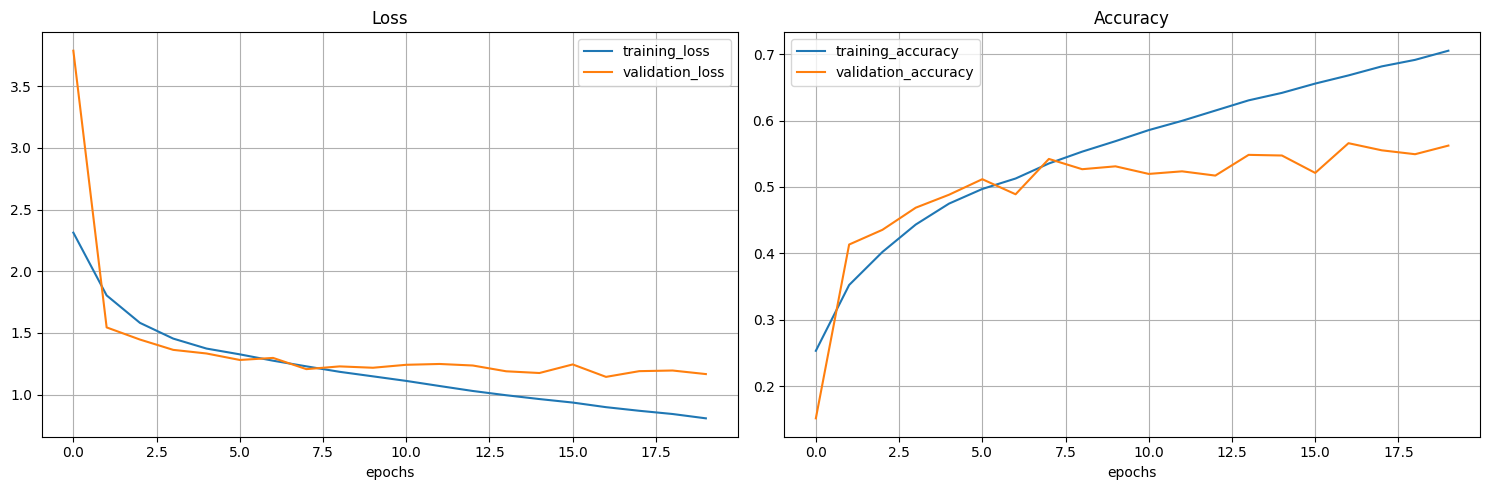

In [121]:
overview_training_statistics_x_y(cnn_model_1, x_test, y_test, cnn_history_1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


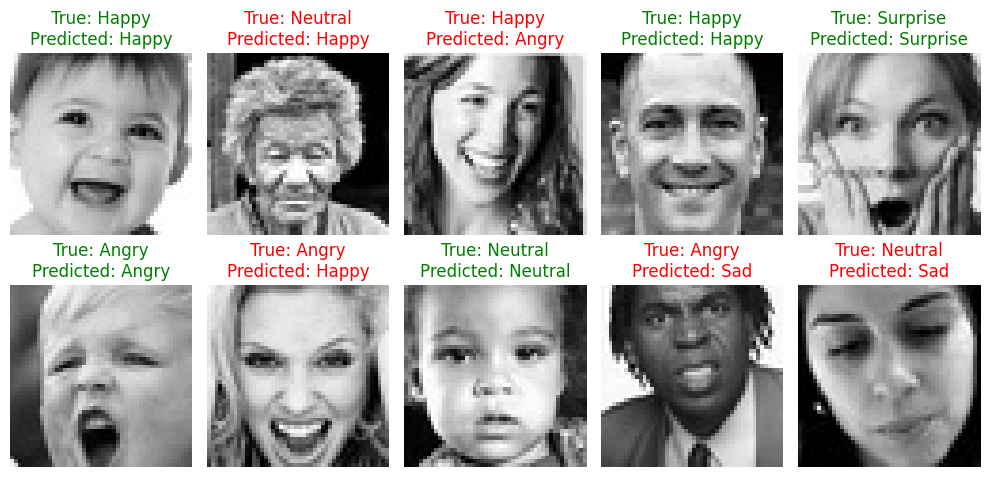

In [35]:
visualize_predictions_x_y(x_test, y_test, cnn_model_1, BATCH_SIZE)

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step
              precision    recall  f1-score   support

           0       0.48      0.42      0.45       958
           1       0.97      0.33      0.50       111
           2       0.50      0.31      0.38      1024
           3       0.79      0.75      0.77      1774
           4       0.56      0.45      0.50      1233
           5       0.36      0.67      0.47      1247
           6       0.79      0.68      0.73       831

    accuracy                           0.56      7178
   macro avg       0.64      0.52      0.54      7178
weighted avg       0.60      0.56      0.56      7178



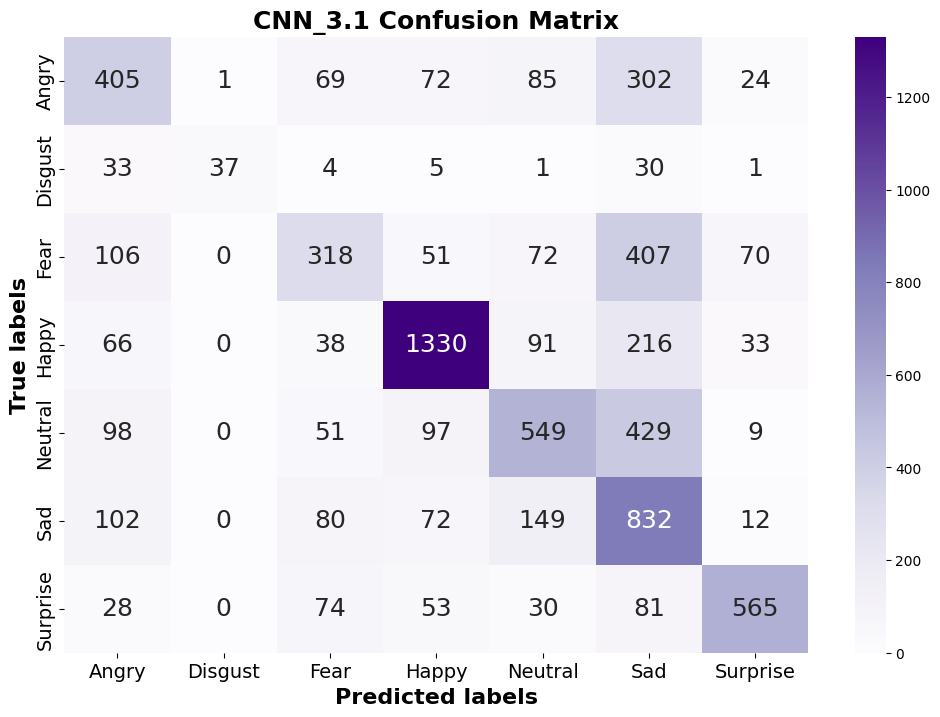

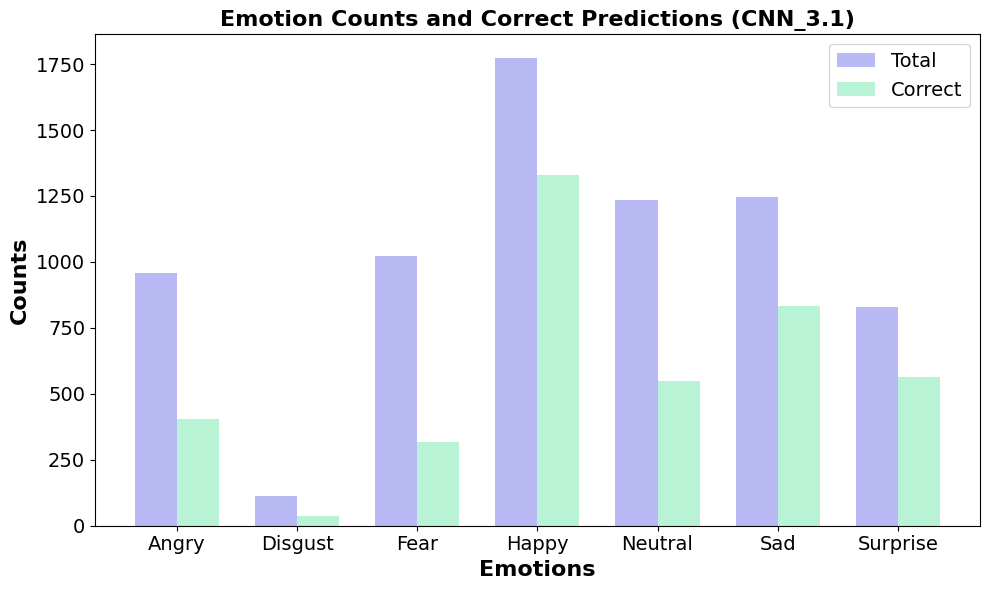

In [122]:
overview_dataset_statistics(cnn_model_1, test_unshuffled_data, "CNN_3.1")

# 3.2 
* BATCH_SIZE = 64
* IMAGE_SIZE = 48
* NUM_CHANNELS = 1
* **EPOCS = 100**
* STEPS_PER_EPOCH = 449 //MAX train 27809 img
* VALIDATION_STEPS = 112 //MAX
* AUGMENTATION IMAGEDATAGENERATOR : NO
* CALLBACKS: NO
* **CNN NUMBER 1**

In [123]:
cnn_model_2 = build_cnn_model(input_shape)

In [124]:
cnn_history_2 = cnn_model_2.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.2244 - loss: 2.5719 - val_accuracy: 0.2669 - val_loss: 3.4921
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3232 - loss: 1.9280 - val_accuracy: 0.3994 - val_loss: 1.5996
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3776 - loss: 1.6822 - val_accuracy: 0.4429 - val_loss: 1.4605
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4232 - loss: 1.5209 - val_accuracy: 0.4645 - val_loss: 1.4093
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4567 - loss: 1.4251 - val_accuracy: 0.4705 - val_loss: 1.4202
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4783 - loss: 1.3668 - val_accuracy: 0.4854 - val_loss: 1.3348
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5093 - loss: 1.3003 - val_accuracy: 0.5118 - val_loss: 1.2668
Epoch 8/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5284 - loss: 1.2521 - val_ac

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5502 - loss: 1.6193
Test Accuracy: 57.66%
Test Loss: 1.44931


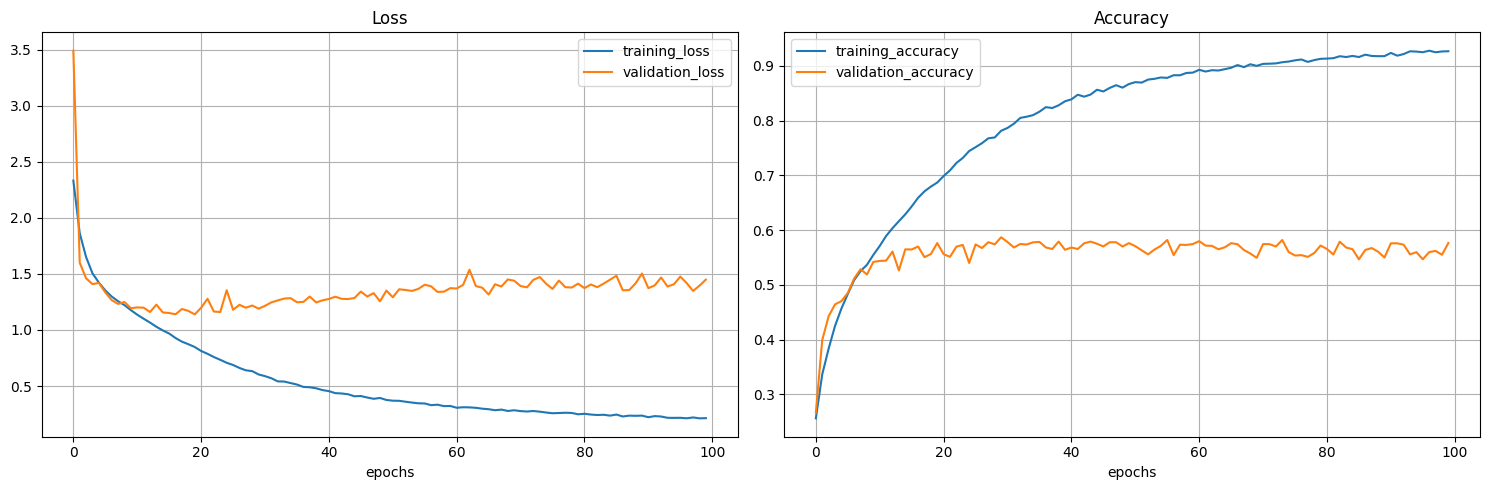

In [125]:
overview_training_statistics_x_y(cnn_model_2, x_test, y_test, cnn_history_2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


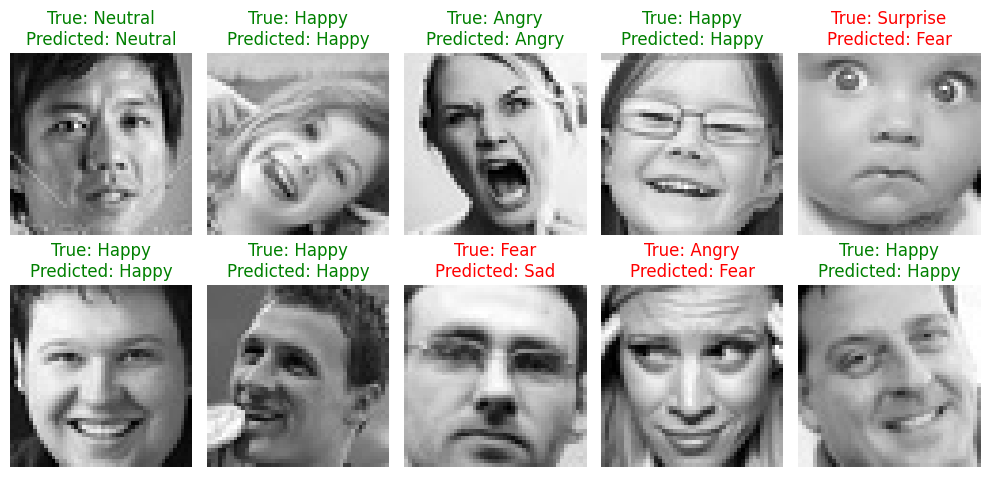

In [51]:
visualize_predictions_x_y(x_test, y_test, cnn_model_2, BATCH_SIZE)

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step
              precision    recall  f1-score   support

           0       0.48      0.43      0.45       958
           1       0.90      0.47      0.62       111
           2       0.48      0.42      0.45      1024
           3       0.79      0.73      0.76      1774
           4       0.51      0.54      0.53      1233
           5       0.41      0.57      0.48      1247
           6       0.83      0.67      0.74       831

    accuracy                           0.58      7178
   macro avg       0.63      0.55      0.58      7178
weighted avg       0.60      0.58      0.58      7178



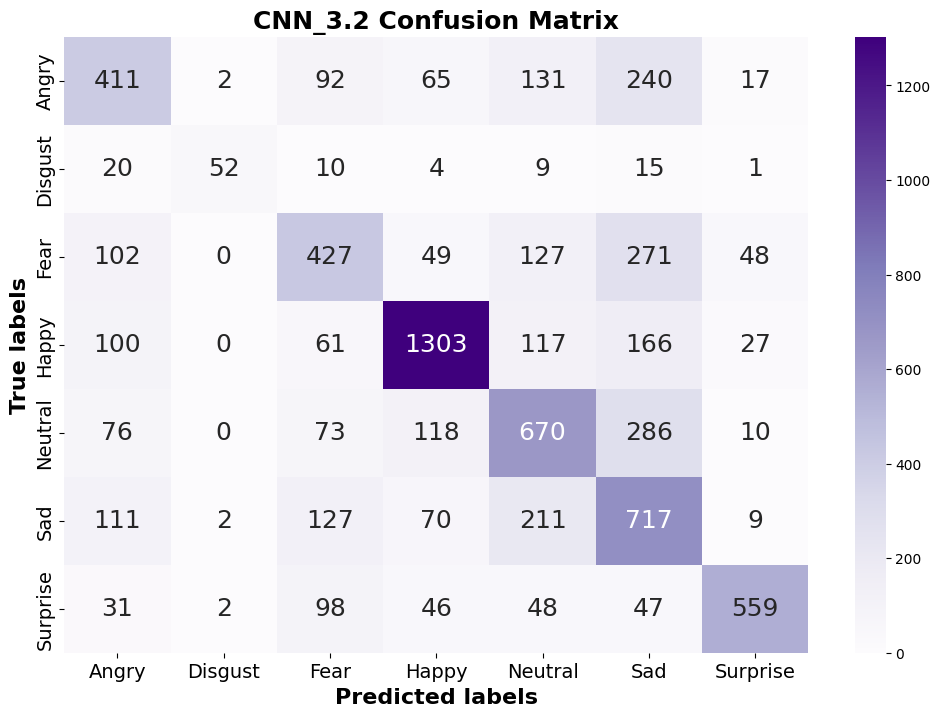

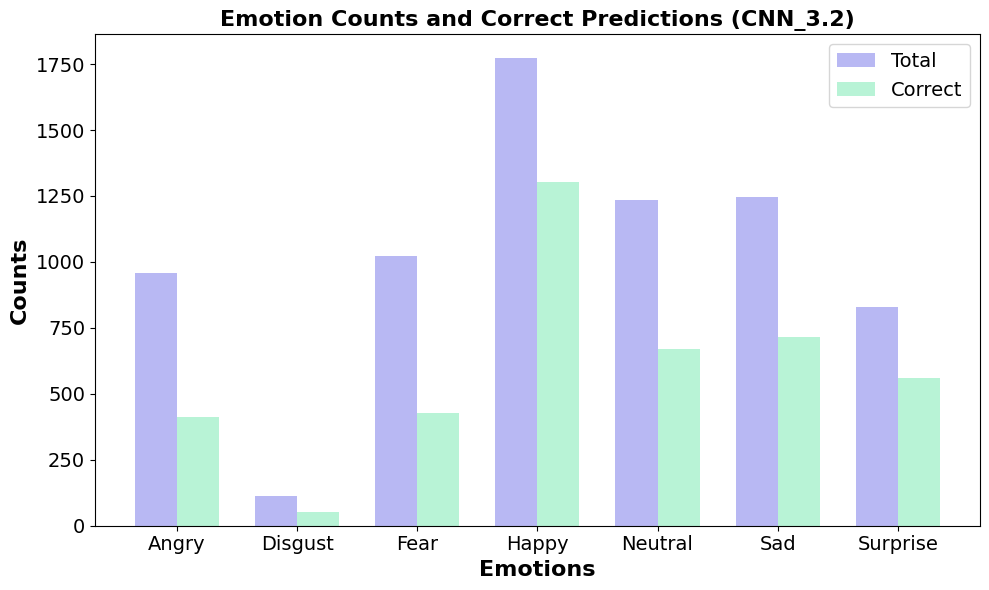

In [126]:
overview_dataset_statistics(cnn_model_2, test_unshuffled_data, "CNN_3.2")

# 3.3 
* BATCH_SIZE = 64
* IMAGE_SIZE = 48
* NUM_CHANNELS = 1
* EPOCS = 20
* STEPS_PER_EPOCH = 359 //MAX train 22868//64
* VALIDATION_STEPS = 89 //MAX 5741//64
* **AUGMENTATION IMAGEDATAGENERATOR : YES**
* CALLBACKS: NO
* **CNN NUMBER 1**

In [ ]:
IMAGE_SIZE=48
NUM_CHANNELS=1
input_shape=(IMAGE_SIZE,IMAGE_SIZE,NUM_CHANNELS)

In [ ]:
train_data, validation_data, test_data, test_unshuffled_data = get_data_generators(IMG_SIZE, NUM_CHANNELS)

In [106]:
cnn_model_3 = build_cnn_model(input_shape)

In [107]:
cnn_history_3 = cnn_model_3.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=validation_data)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 0.1766 - loss: 2.7096 - val_accuracy: 0.1751 - val_loss: 2.1569
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.1987 - loss: 2.2183 - val_accuracy: 0.2775 - val_loss: 1.7601
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.2224 - loss: 1.9984 - val_accuracy: 0.2986 - val_loss: 1.7357
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.2329 - loss: 1.8933 - val_accuracy: 0.3012 - val_loss: 1.7442
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.2550 - loss: 1.8321 - val_accuracy: 0.2677 - val_loss: 1.7788
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.2660 - loss: 1.7956 - val_accuracy: 0.3099 - val_loss: 1.6739
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.2852 - loss: 1.7624 - val_accuracy: 0.3174 - val_loss: 1.6568
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.3106 - loss: 1.7123

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.4559 - loss: 1.4534
Test Accuracy: 45.33%
Test Loss: 1.44885


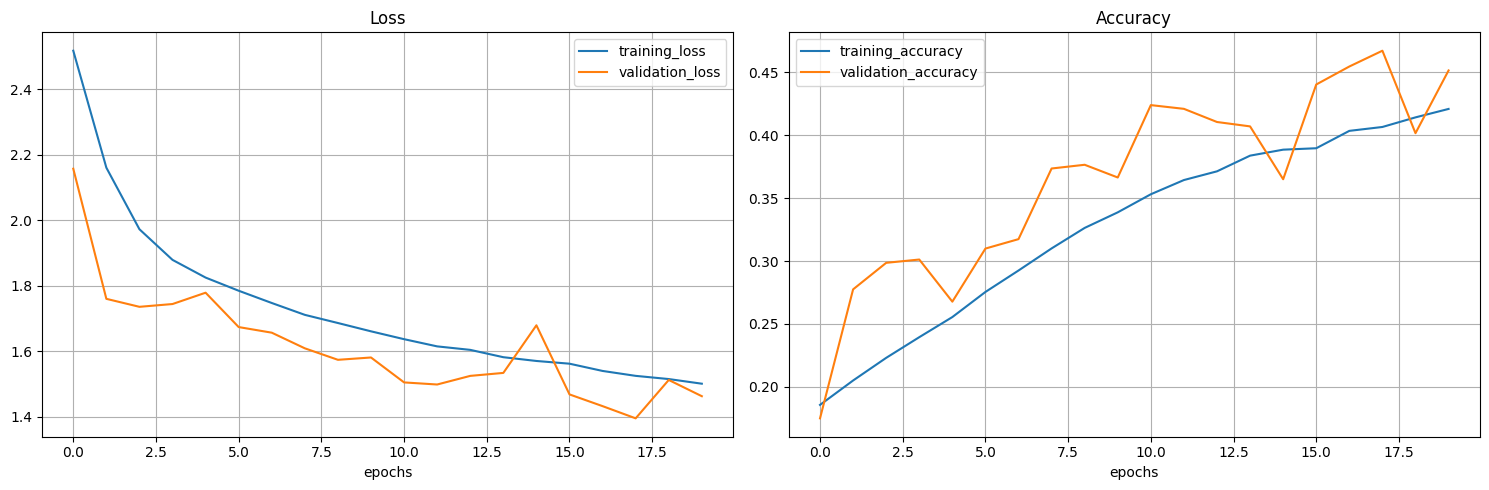

In [114]:
overview_training_statistics(cnn_model_3, test_data, cnn_history_3)

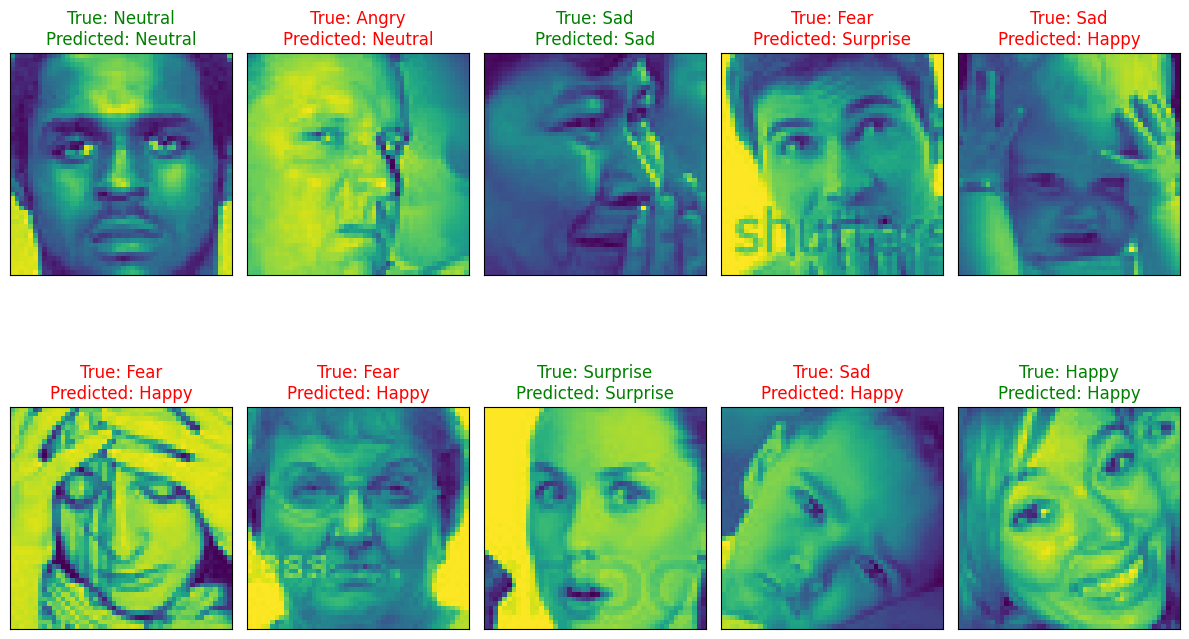

In [111]:
visualize_predictions(test_data, BATCH_SIZE, cnn_model_3)

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step
              precision    recall  f1-score   support

           0       0.43      0.16      0.23       958
           1       0.00      0.00      0.00       111
           2       0.32      0.04      0.07      1024
           3       0.46      0.90      0.61      1774
           4       0.38      0.52      0.44      1233
           5       0.44      0.20      0.28      1247
           6       0.56      0.69      0.62       831

    accuracy                           0.45      7178
   macro avg       0.37      0.36      0.32      7178
weighted avg       0.43      0.45      0.39      7178



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


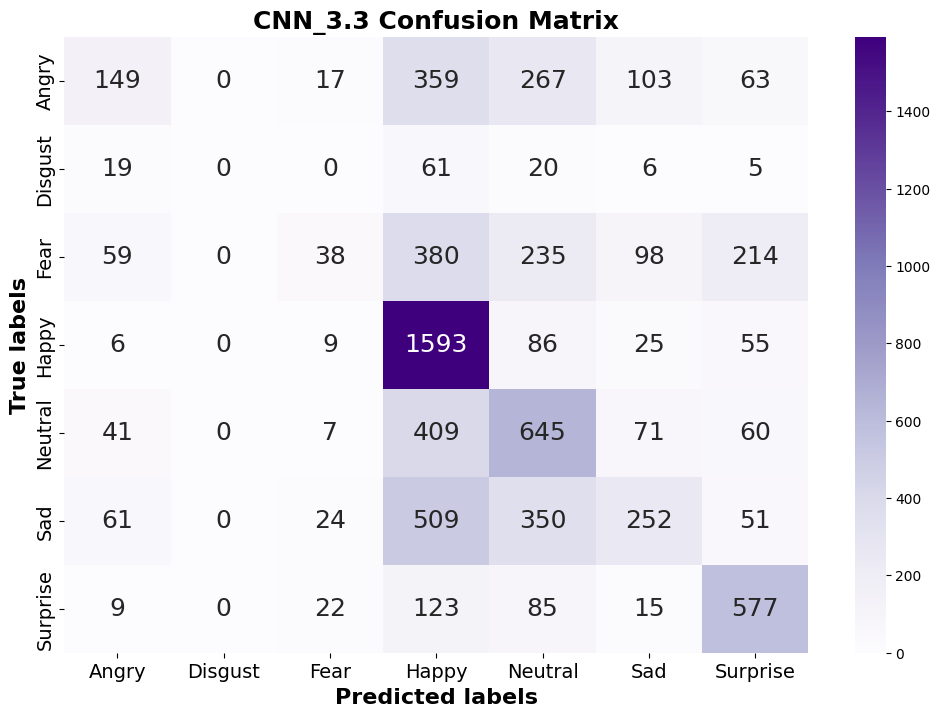

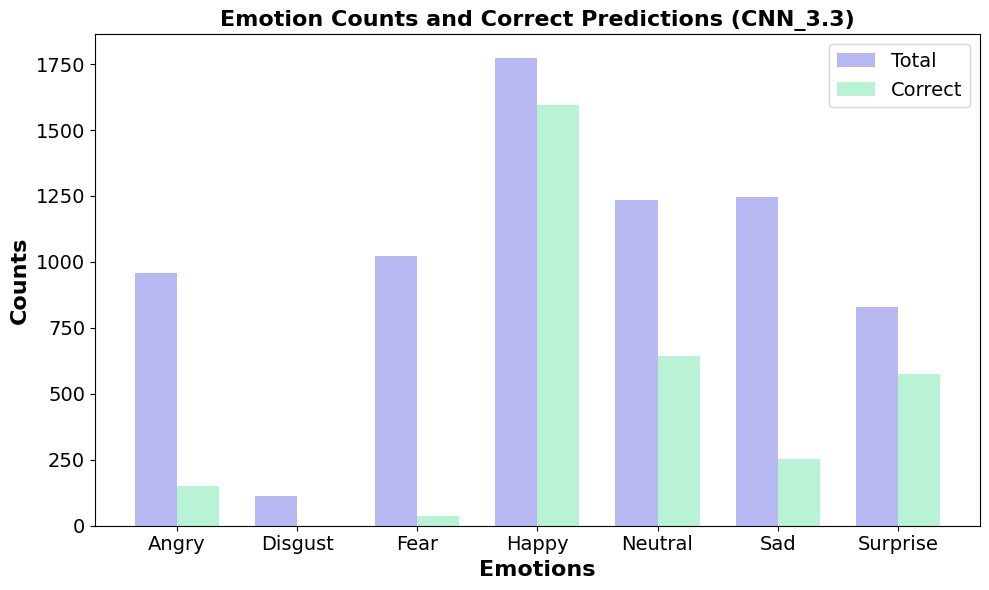

In [115]:
overview_dataset_statistics(cnn_model_3, test_unshuffled_data, "CNN_3.3")

# 3.4
* BATCH_SIZE = 64
* **IMAGE_SIZE = 224**
* **NUM_CHANNELS = 3**
* EPOCS = 20
* STEPS_PER_EPOCH = 359 //MAX
* VALIDATION_STEPS = 89 //MAX
* AUGMENTATION IMAGEDATAGENERATOR : YES
* CALLBACKS: NO
* **CNN NUMBER 1**

In [15]:
IMG_SIZE=224
NUM_CHANNELS=3
input_shape=(IMG_SIZE, IMG_SIZE,NUM_CHANNELS)

In [16]:
train_data, validation_data, test_data, test_unshuffled_data = get_data_generators(IMG_SIZE, NUM_CHANNELS)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [130]:
cnn_model_4 = build_cnn_model(input_shape)

In [131]:
cnn_history_4 = cnn_model_4.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=validation_data)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 313s 801ms/step - accuracy: 0.1656 - loss: 2.7722 - val_accuracy: 0.1961 - val_loss: 6.8662
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 276s 755ms/step - accuracy: 0.1938 - loss: 2.2413 - val_accuracy: 0.2183 - val_loss: 7.1208
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 277s 757ms/step - accuracy: 0.2099 - loss: 2.0579 - val_accuracy: 0.2278 - val_loss: 7.7169
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 276s 755ms/step - accuracy: 0.2133 - loss: 1.9417 - val_accuracy: 0.2301 - val_loss: 7.9810
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 277s 758ms/step - accuracy: 0.2352 - loss: 1.8670 - val_accuracy: 0.2129 - val_loss: 11.0463
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 274s 749ms/step - accuracy: 0.2454 - loss: 1.8281 - val_accuracy: 0.2489 - val_loss: 9.7557
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 275s 752ms/step - accuracy: 0.2576 - loss: 1.8008 - val_accuracy: 0.1960 - val_loss: 8.8472
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 277s 759ms/step - accuracy: 0.2643 - loss: 1.7

113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - accuracy: 0.3058 - loss: 1.8509
Test Accuracy: 30.22%
Test Loss: 1.87990


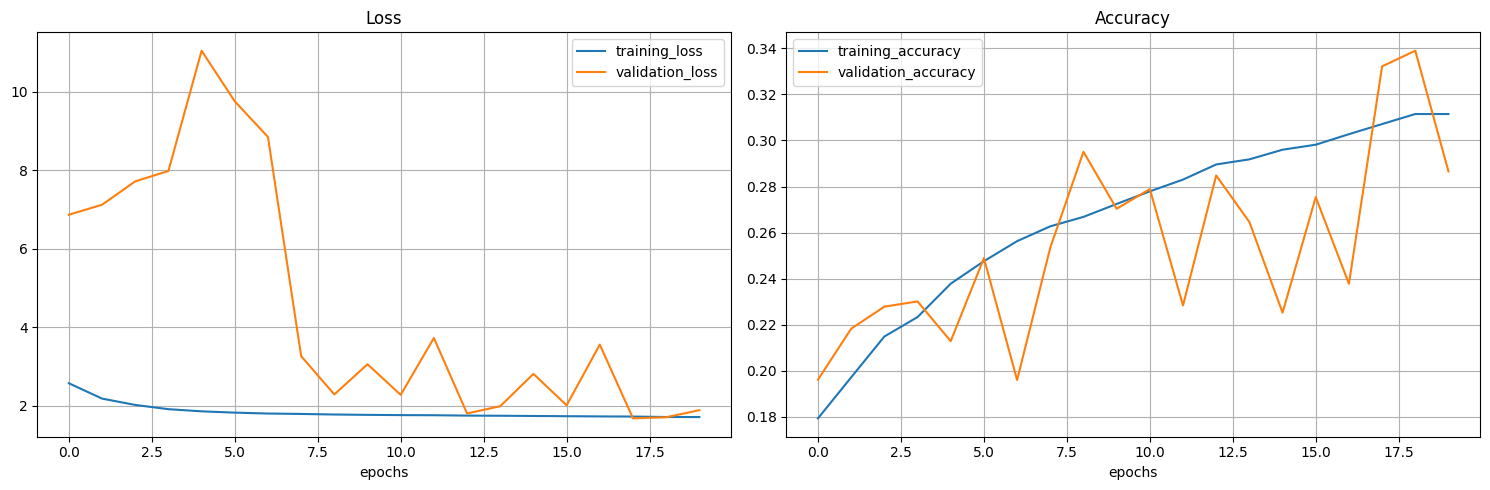

In [134]:
overview_training_statistics(cnn_model_4, test_data, cnn_history_4)

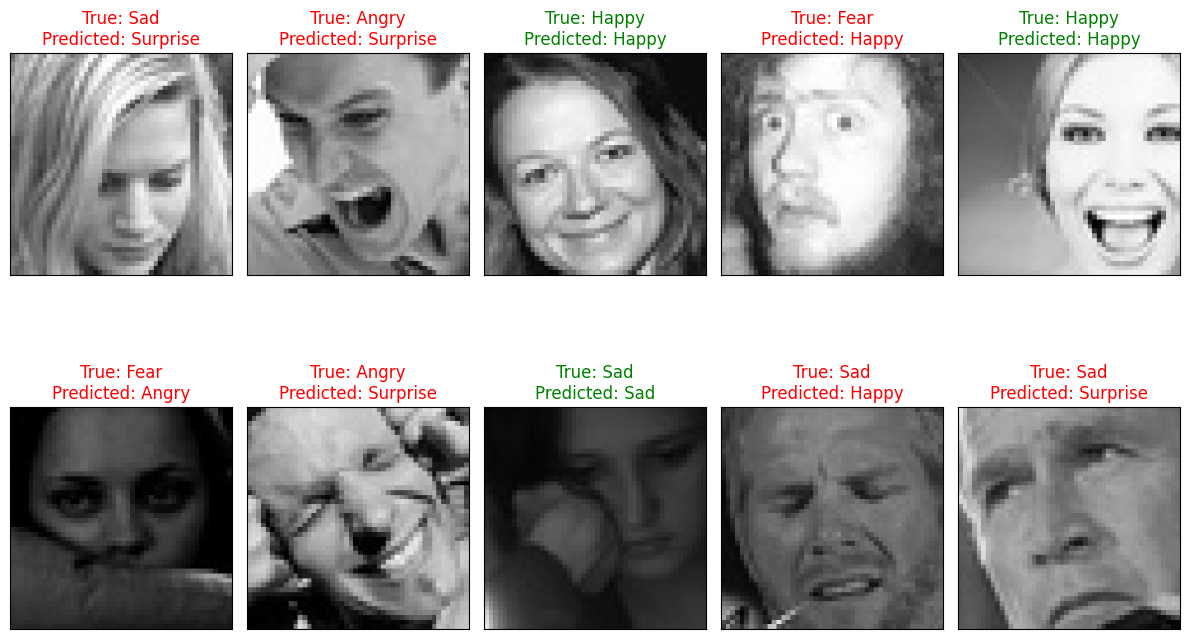

In [90]:
visualize_predictions(test_data, BATCH_SIZE, cnn_model_4)

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step
              precision    recall  f1-score   support

           0       0.28      0.19      0.22       958
           1       0.00      0.00      0.00       111
           2       0.24      0.05      0.08      1024
           3       0.45      0.60      0.51      1774
           4       0.31      0.52      0.39      1233
           5       0.32      0.28      0.30      1247
           6       0.57      0.50      0.54       831

    accuracy                           0.38      7178
   macro avg       0.31      0.31      0.29      7178
weighted avg       0.36      0.38      0.35      7178



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


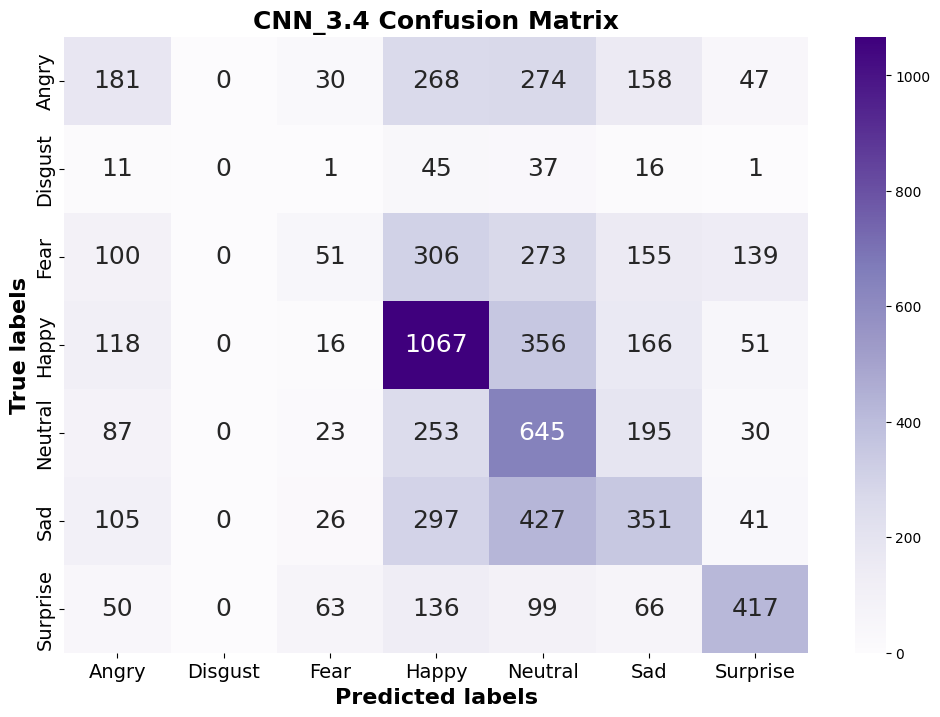

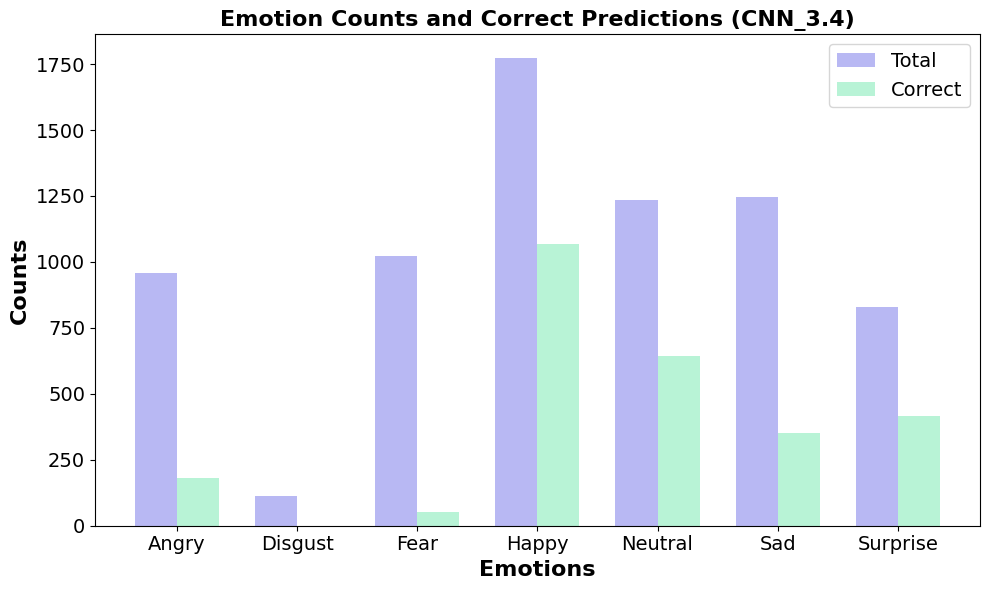

In [91]:
overview_dataset_statistics(cnn_model_4, test_unshuffled_data, "CNN_3.4")

# 3.5
* BATCH_SIZE = 64
* **IMAGE_SIZE = 224**
* **NUM_CHANNELS = 3**
* EPOCS = 20
* **VALIDATION_STEPS = 89** //MAX 
* AUGMENTATION IMAGEDATAGENERATOR : YES
* CALLBACKS: NO
* **CNN NUMBER 2**

In [19]:
cnn_model_5 = build_cnn_model_2(input_shape)

In [22]:
cnn_history_5 = cnn_model_5.fit(train_data, epochs=EPOCHS, validation_data = validation_data, batch_size=BATCH_SIZE)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/359 ━━━━━━━━━━━━━━━━━━━━ 2:17:54 23s/step - accuracy: 0.1406 - loss: 3.2997

I0000 00:00:1718128131.477406     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718128131.497078     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2226 - loss: 9.6512

W0000 00:00:1718128543.756813     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.2227 - loss: 9.6352 - val_accuracy: 0.1319 - val_loss: 18.5780
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.2472 - loss: 1.8930 - val_accuracy: 0.2257 - val_loss: 2.6016
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.2507 - loss: 1.8618 - val_accuracy: 0.2515 - val_loss: 1.8414
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.2554 - loss: 1.8363 - val_accuracy: 0.2402 - val_loss: 2.1722
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.2520 - loss: 1.8171 - val_accuracy: 0.2510 - val_loss: 1.8149
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.2519 - loss: 1.8177 - val_accuracy: 0.2513 - val_loss: 1.8127
Epoch 9/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.2545 - loss: 1.8082 - val_accuracy: 0.2513 - val_loss: 1.8118
Epoch 10/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.2538 - loss: 1.8117 - val_accuracy: 0.2

113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 407ms/step - accuracy: 0.2458 - loss: 1.8151
Test Accuracy: 24.71%
Test Loss: 1.81323


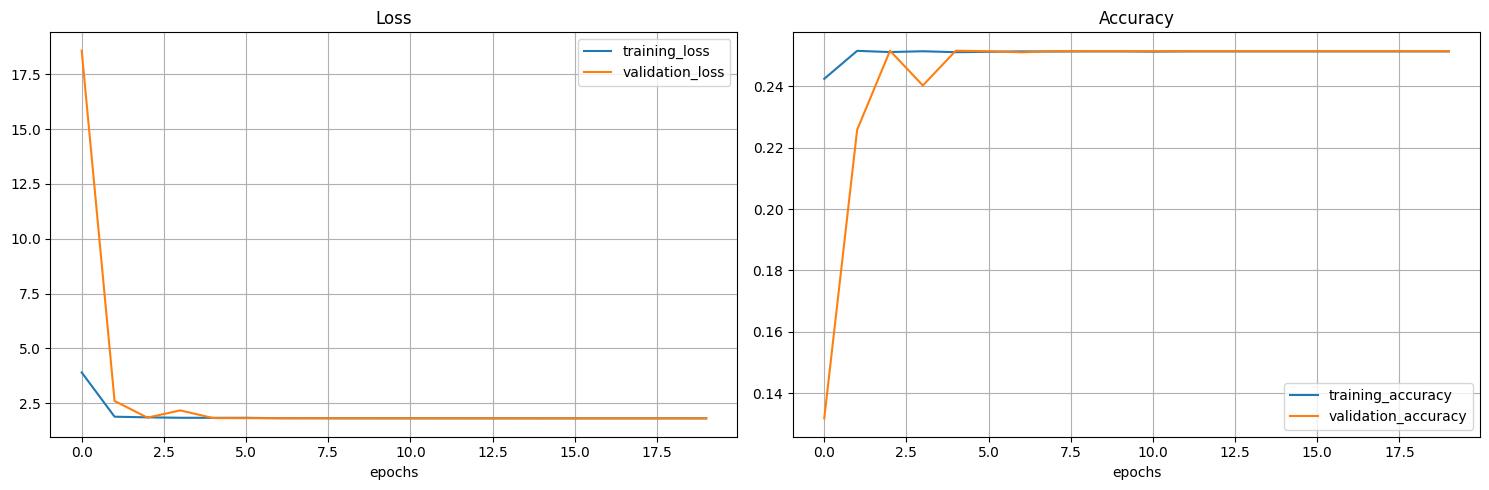

In [23]:
overview_training_statistics(cnn_model_5, test_data, cnn_history_5)

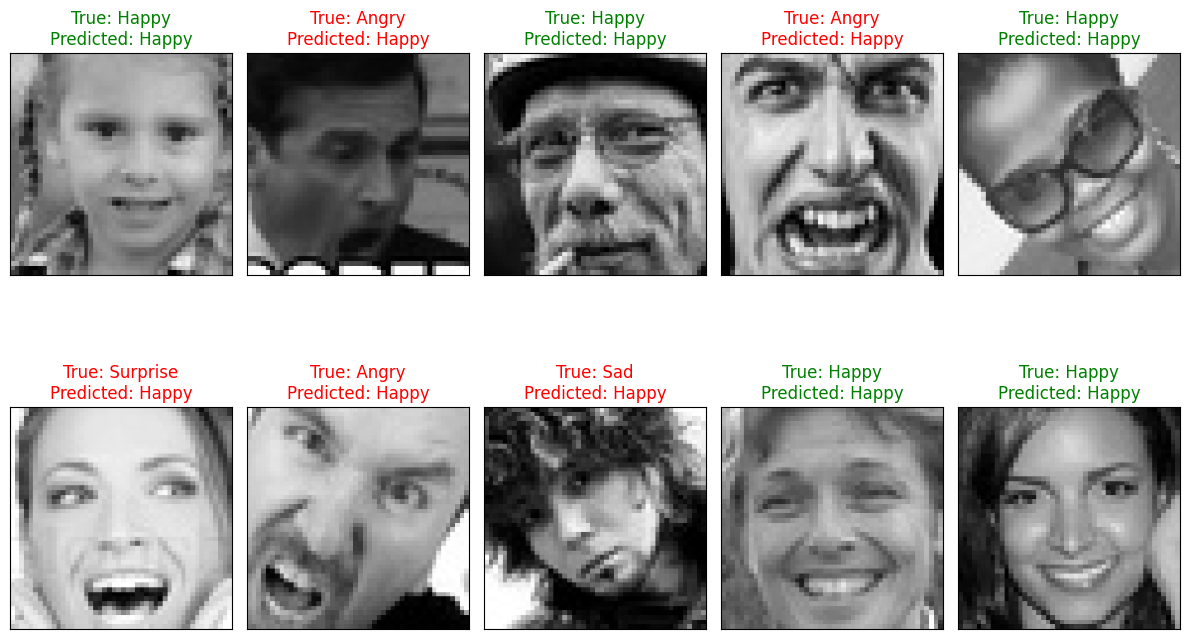

In [34]:
visualize_predictions(test_data, BATCH_SIZE, cnn_model_5)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1024
           3       0.25      1.00      0.40      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


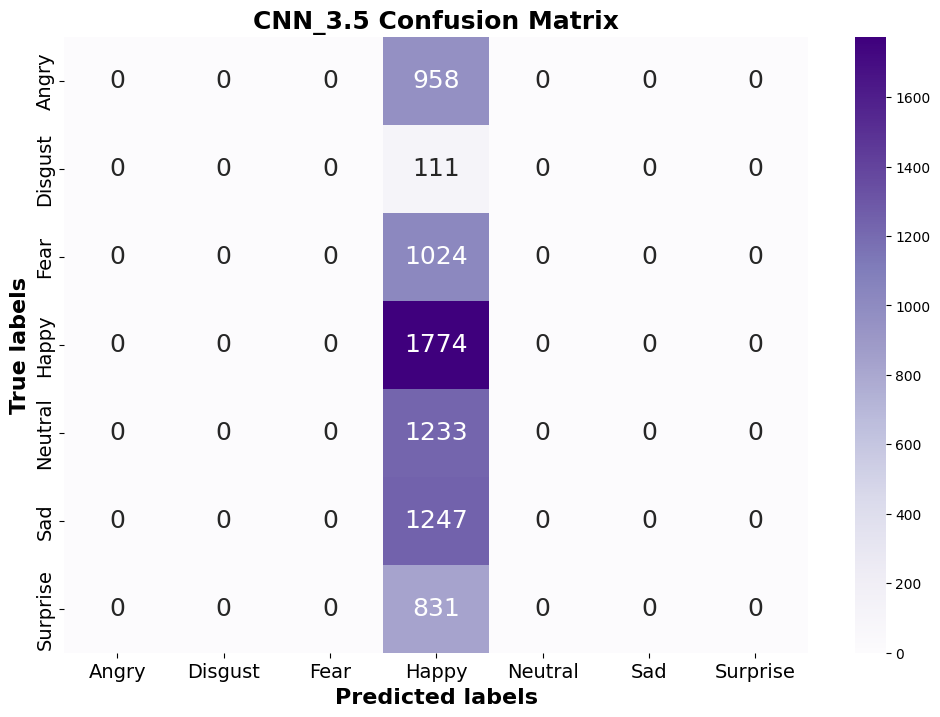

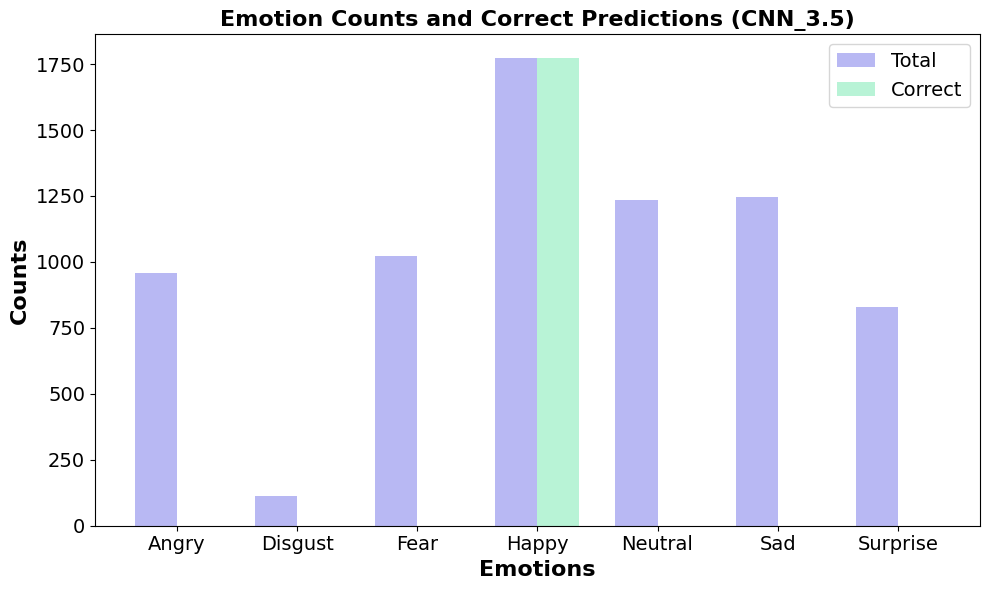

In [33]:
overview_dataset_statistics(cnn_model_5, test_unshuffled_data, "CNN_3.5")

Epoch 1/20


W0000 00:00:1718137185.793880     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


246/359 ━━━━━━━━━━━━━━━━━━━━ 1:57 1s/step - accuracy: 0.1822 - loss: 3.0272   

W0000 00:00:1718137439.844509     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.1831 - loss: 2.8976

W0000 00:00:1718137545.051173     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.1831 - loss: 2.8967 - val_accuracy: 0.2588 - val_loss: 1.8481
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.2117 - loss: 2.3177 - val_accuracy: 0.2682 - val_loss: 1.8255
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.2145 - loss: 2.2009 - val_accuracy: 0.2743 - val_loss: 1.7910
Epoch 4/20
 19/359 ━━━━━━━━━━━━━━━━━━━━ 5:03 892ms/step - accuracy: 0.2382 - loss: 2.1307

# 3.6
* BATCH_SIZE = 64
* **IMAGE_SIZE = 224**
* **NUM_CHANNELS = 3**
* EPOCS = 20
* **STEPS_PER_EPOCH = 359** //MAX
* **VALIDATION_STEPS = 89** //MAX
* AUGMENTATION IMAGEDATAGENERATOR : YES
* CALLBACKS: NO
* **CNN NUMBER 3**

In [21]:
cnn_model_6 = build_cnn_model_3(input_shape)

In [ ]:
cnn_history_6 = cnn_model_6.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=validation_data)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718112798.189943     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718112798.214931     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/359 ━━━━━━━━━━━━━━━━━━━━ 4:20 1s/step - accuracy: 0.1688 - loss: 2.8673

W0000 00:00:1718112956.867588     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1754 - loss: 2.6989

W0000 00:00:1718113221.322317     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 594s 1s/step - accuracy: 0.1754 - loss: 2.6984 - val_accuracy: 0.2418 - val_loss: 1.8455
Epoch 2/20


W0000 00:00:1718113333.057942     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 357s 980ms/step - accuracy: 0.2071 - loss: 2.2022 - val_accuracy: 0.2318 - val_loss: 1.9247
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 338s 928ms/step - accuracy: 0.2212 - loss: 2.0178 - val_accuracy: 0.2306 - val_loss: 2.0871
Epoch 4/20
194/359 ━━━━━━━━━━━━━━━━━━━━ 2:04 752ms/step - accuracy: 0.2333 - loss: 1.8968

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.2971 - loss: 1.7534
Test Accuracy: 28.84%
Test Loss: 1.76425


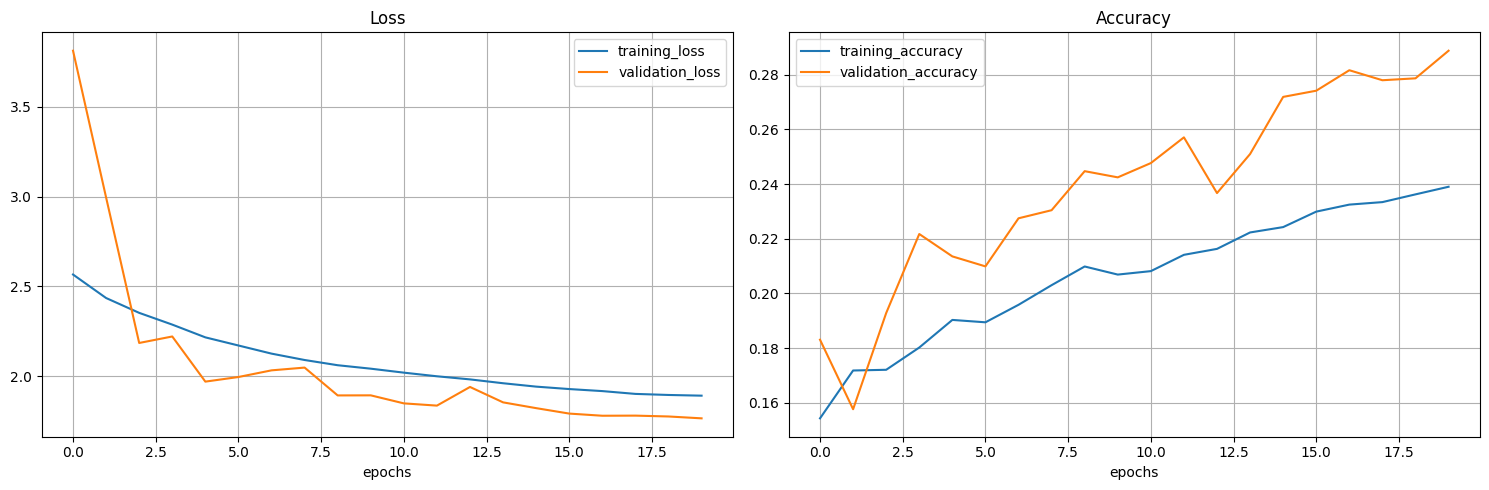

In [39]:
overview_training_statistics(cnn_model_6, test_data, cnn_history_6)

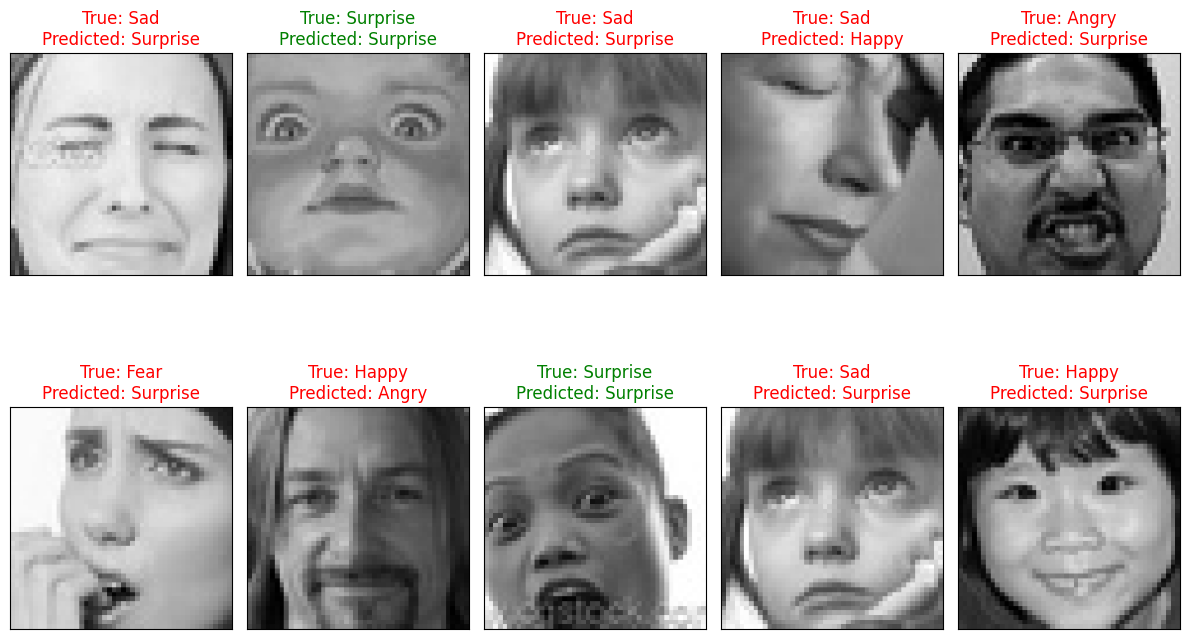

In [47]:
visualize_predictions(test_data, BATCH_SIZE, cnn_model_6)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step
              precision    recall  f1-score   support

           0       0.20      0.05      0.08       958
           1       0.00      0.00      0.00       111
           2       0.20      0.05      0.07      1024
           3       0.30      0.73      0.42      1774
           4       0.30      0.20      0.24      1233
           5       0.25      0.20      0.22      1247
           6       0.37      0.21      0.27       831

    accuracy                           0.29      7178
   macro avg       0.23      0.21      0.19      7178
weighted avg       0.27      0.29      0.24      7178



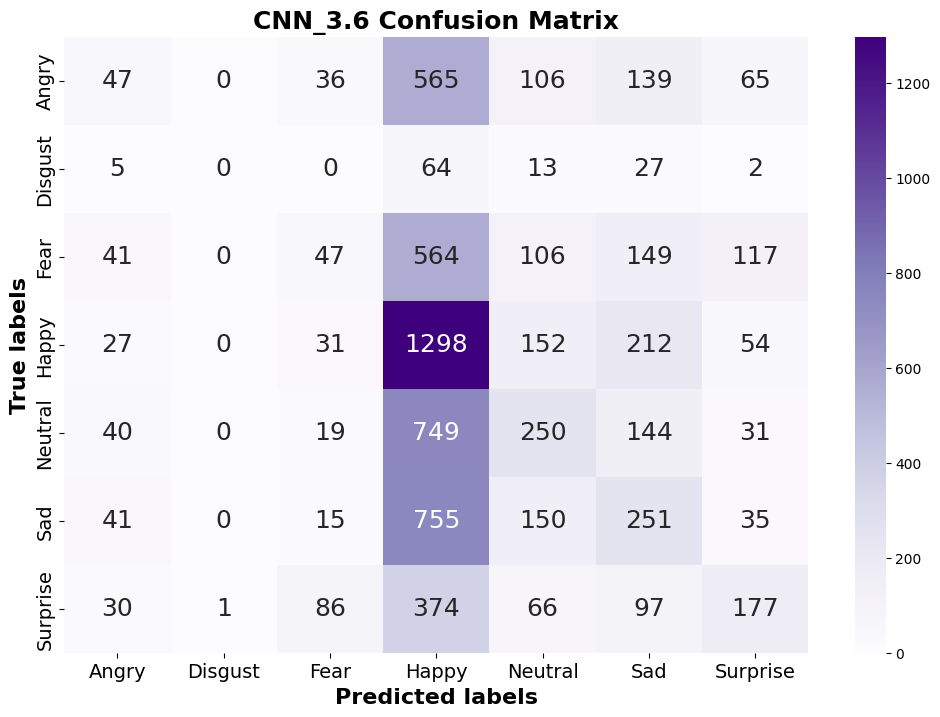

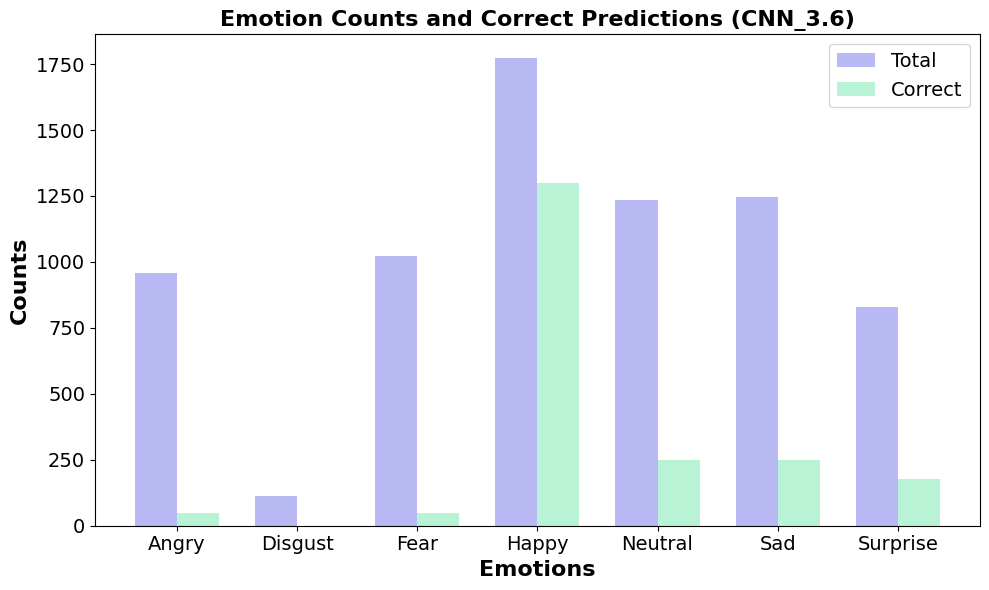

In [42]:
overview_dataset_statistics(cnn_model_6, test_unshuffled_data,"CNN_3.6")

# 3.7 callbacks
* BATCH_SIZE = 64
* IMAGE_SIZE = 224
* NUM_CHANNELS = 3 
* EPOCS = 20
* STEPS_PER_EPOCH = 359 //MAX
* VALIDATION_STEPS = 89 //MAX
* **CALLBACKS: YES**
* **CNN NUMBER 3**

In [29]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)
reducing_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000005,verbose=1)

callbacks = [early_stopping_callback, reducing_lr_callback]

In [30]:
cnn_model_7 = build_cnn_model_3(input_shape)

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)
reducing_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000005, verbose=1)

callbacks = [early_stopping_callback, reducing_lr_callback]

In [34]:
cnn_model_7 = build_cnn_model_3((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
cnn_history_7 = cnn_model_7.fit(train_data, validation_data=validation_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 340s 851ms/step - accuracy: 0.1775 - loss: 2.7122 - val_accuracy: 0.2527 - val_loss: 1.9743 - learning_rate: 0.0010
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 312s 856ms/step - accuracy: 0.2013 - loss: 2.2042 - val_accuracy: 0.2771 - val_loss: 1.7794 - learning_rate: 0.0010
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 284s 774ms/step - accuracy: 0.2157 - loss: 2.0025 - val_accuracy: 0.2872 - val_loss: 1.7561 - learning_rate: 0.0010
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 284s 777ms/step - accuracy: 0.2372 - loss: 1.8914 - val_accuracy: 0.3015 - val_loss: 1.7299 - learning_rate: 0.0010
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 282s 771ms/step - accuracy: 0.2480 - loss: 1.8404 - val_accuracy: 0.2196 - val_loss: 2.0829 - learning_rate: 0.0010
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 286s 782ms/step - accuracy: 0.2664 - loss: 1.7994 - val_accuracy: 0.3130 - val_loss: 1.7196 - learning_rate: 0.0010
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 280s 766ms/step - accura

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.5106 - loss: 1.3007
Test Accuracy: 49.92%
Test Loss: 1.63695


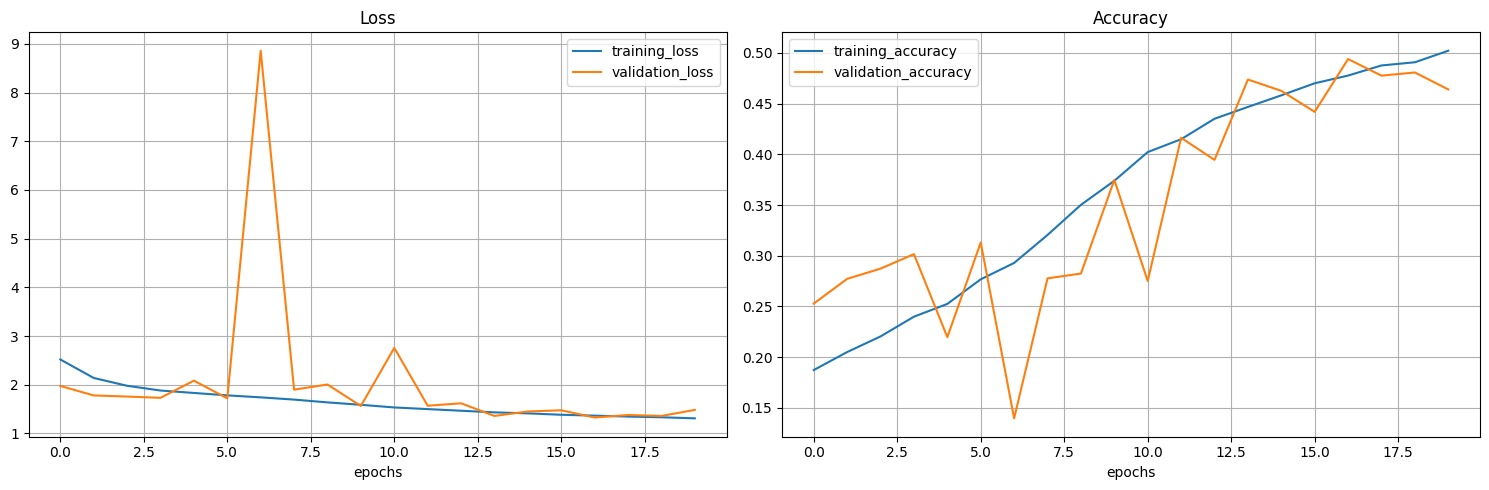

In [37]:
overview_training_statistics(cnn_model_7, test_data, cnn_history_7)

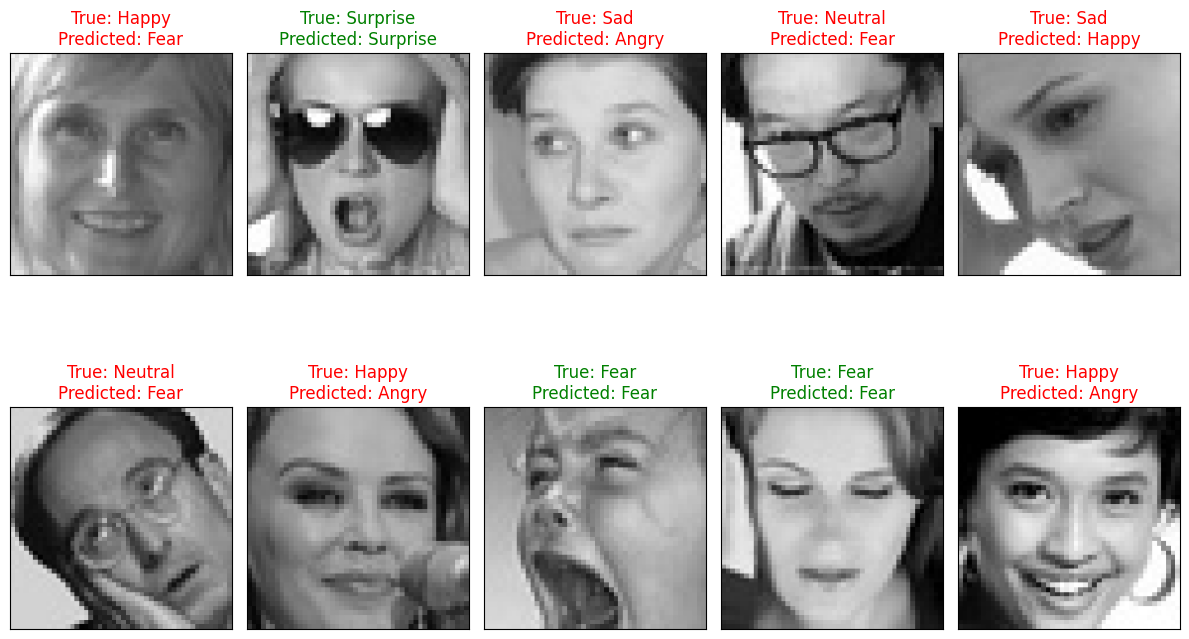

In [47]:
visualize_predictions(test_data, BATCH_SIZE, cnn_model_7)

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step
              precision    recall  f1-score   support

           0       0.45      0.15      0.22       958
           1       0.00      0.00      0.00       111
           2       0.30      0.10      0.15      1024
           3       0.66      0.78      0.72      1774
           4       0.41      0.58      0.48      1233
           5       0.39      0.47      0.42      1247
           6       0.54      0.77      0.64       831

    accuracy                           0.50      7178
   macro avg       0.39      0.41      0.38      7178
weighted avg       0.47      0.50      0.46      7178



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


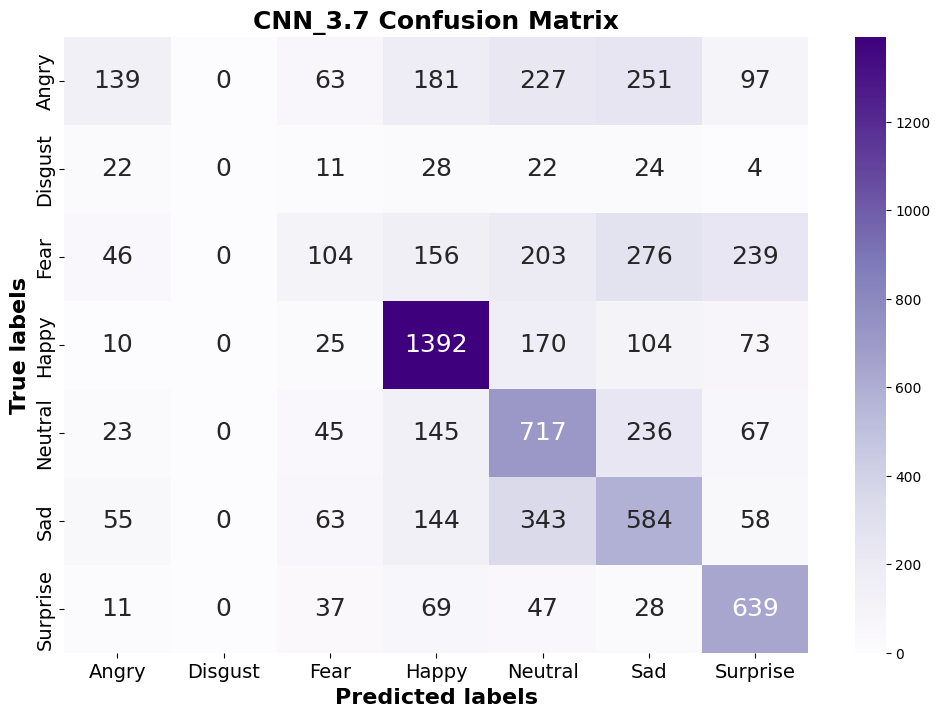

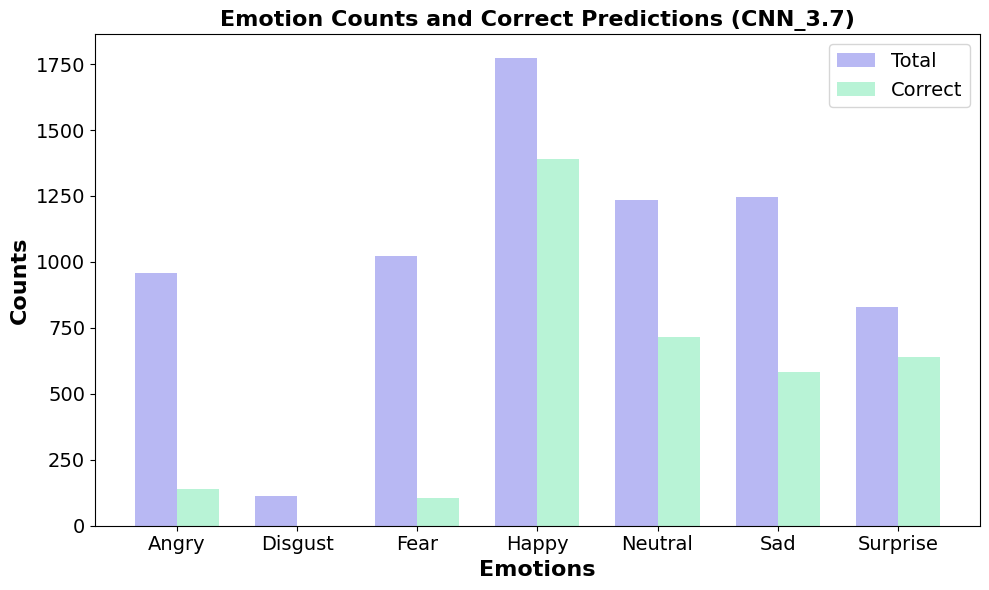

In [44]:
overview_dataset_statistics(cnn_model_7, test_unshuffled_data,"CNN_3.7")

# 3.8 
* BATCH_SIZE = 64
* **IMAGE_SIZE = 48**
* **NUM_CHANNELS = 3**
* EPOCS = 20
* STEPS_PER_EPOCH = 359 //MAX
* VALIDATION_STEPS = 89 //MAX
* **CALLBACKS: YES**
* **CNN NUMBER 3**

In [12]:
IMG_SIZE=48
NUM_CHANNELS=3
EPOCHS=20
input_shape=(IMG_SIZE,IMG_SIZE,NUM_CHANNELS)

In [8]:
train_data, validation_data, test_data, test_unshuffled_data = get_data_generators(IMG_SIZE, NUM_CHANNELS)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [17]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
reducing_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000005, verbose=1)
callbacks = [early_stopping_callback, reducing_lr_callback]

In [21]:
cnn_model_8 = build_cnn_model_3(input_shape)

In [22]:
cnn_history_8 = cnn_model_8.fit(train_data, validation_data=validation_data, epochs=50, callbacks=callbacks)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/359 ━━━━━━━━━━━━━━━━━━━━ 1:56:02 19s/step - accuracy: 0.1875 - loss: 3.1825

I0000 00:00:1718030023.317320     234 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 174s 431ms/step - accuracy: 0.1680 - loss: 2.7932 - val_accuracy: 0.2529 - val_loss: 2.0988 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 135ms/step - accuracy: 0.1983 - loss: 2.2416 - val_accuracy: 0.2583 - val_loss: 1.8817 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 133ms/step - accuracy: 0.2210 - loss: 2.0097 - val_accuracy: 0.2430 - val_loss: 1.8038 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 137ms/step - accuracy: 0.2315 - loss: 1.9114 - val_accuracy: 0.2681 - val_loss: 1.7663 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 137ms/step - accuracy: 0.2557 - loss: 1.8320 - val_accuracy: 0.2947 - val_loss: 1.7081 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 138ms/step - accuracy: 0.2775 - loss: 1.7759 - val_accuracy: 0.2639 - val_loss: 1.9128 - learning_rate: 0.0010
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 138ms/step - accuracy: 0.3130 - loss

113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 200ms/step - accuracy: 0.5858 - loss: 1.0751
Test Accuracy: 58.21%
Test Loss: 1.08178


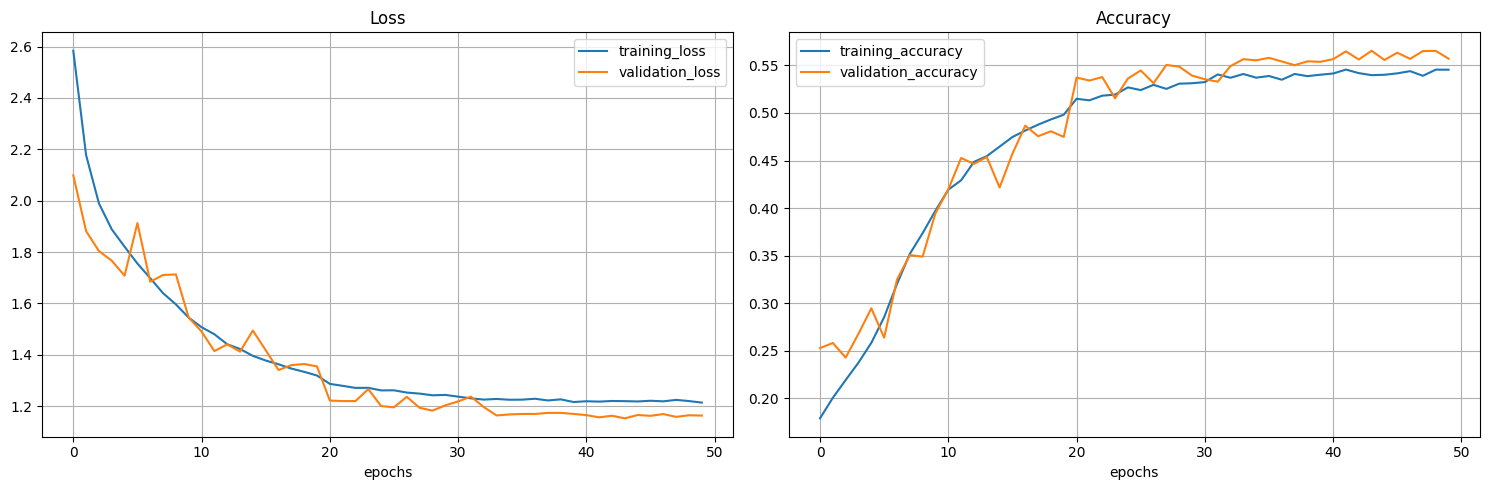

In [34]:
overview_training_statistics(cnn_model_8, test_data, cnn_history_8)

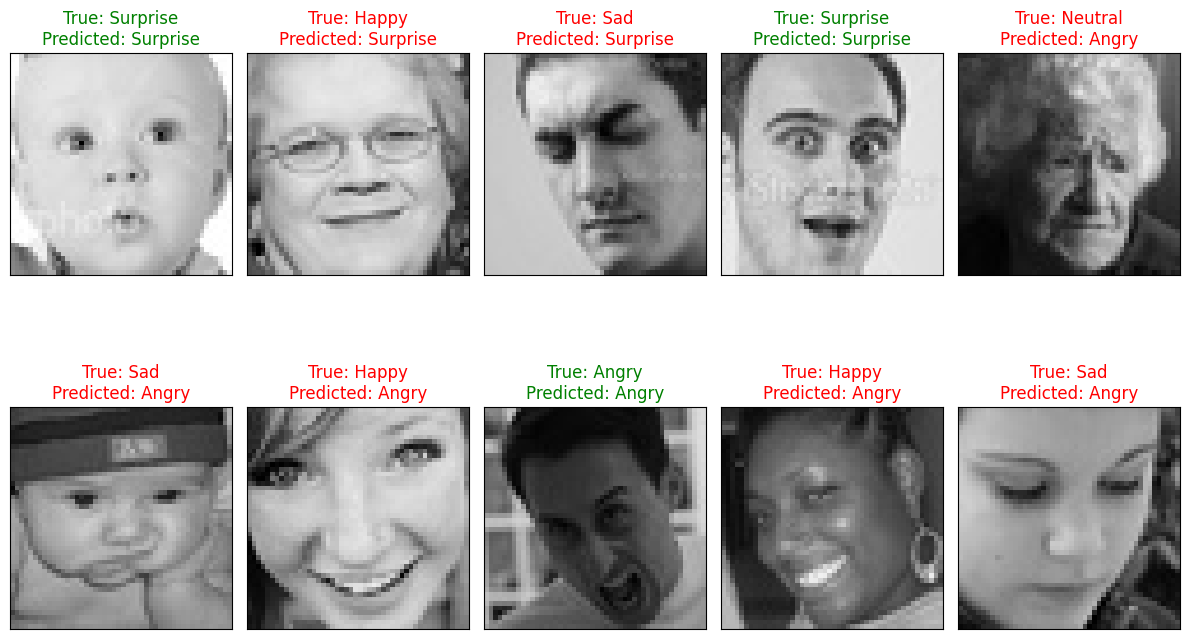

In [45]:
visualize_predictions(test_data, BATCH_SIZE, cnn_model_8)

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step
              precision    recall  f1-score   support

           0       0.44      0.59      0.50       958
           1       0.60      0.14      0.22       111
           2       0.44      0.17      0.25      1024
           3       0.83      0.83      0.83      1774
           4       0.47      0.69      0.56      1233
           5       0.49      0.34      0.40      1247
           6       0.67      0.81      0.73       831

    accuracy                           0.58      7178
   macro avg       0.56      0.51      0.50      7178
weighted avg       0.58      0.58      0.56      7178



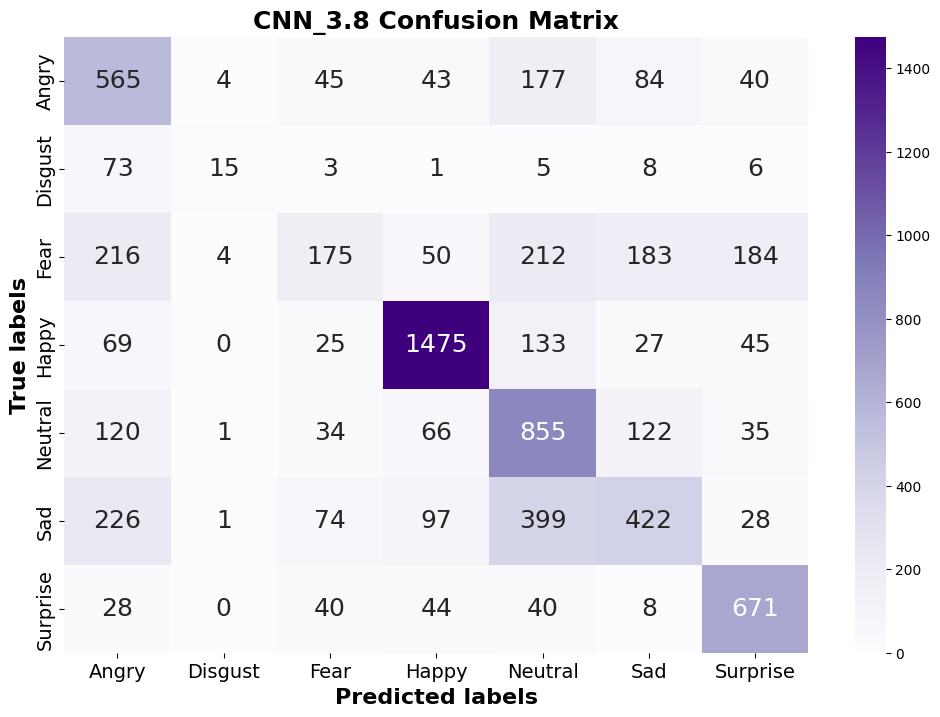

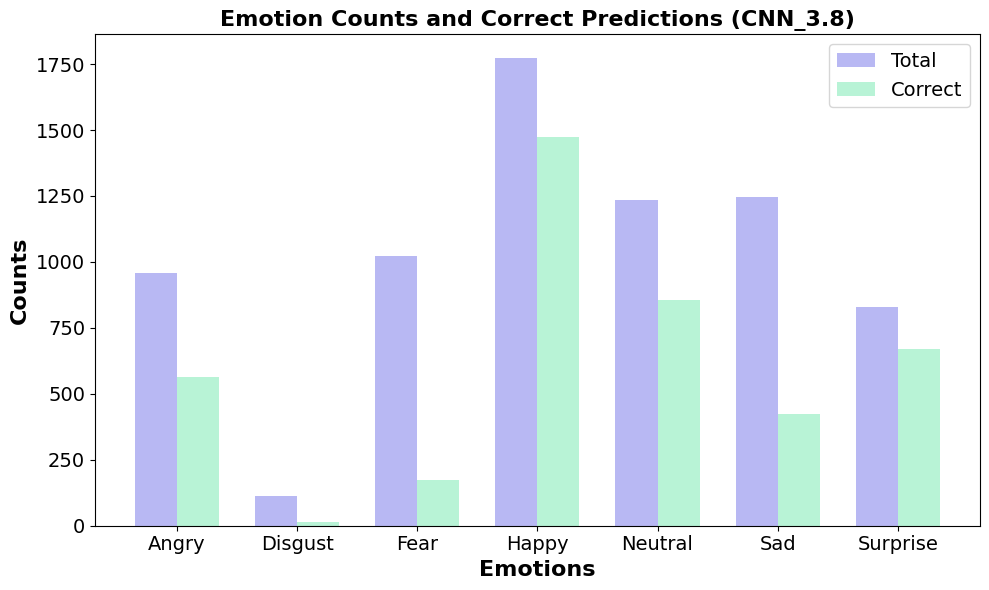

In [41]:
overview_dataset_statistics(cnn_model_8, test_unshuffled_data,"CNN_3.8")